# 10. 도로 영역을 찾자! - 세그멘테이션 모델 만들기

**시맨틱 세그멘테이션을 이용해 자율주행 차량을 위해 도로영역을 찾는 모델을 간단히 만들어 본다.**

## 10-5. 프로젝트 : 개선된 U-Net 모델 만들기

---

### 목차
- Step 1. KITTI 데이터셋 수집과 구축
- Step 2. U-Net++ 모델의 구현
- Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

---

### 라이브러리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- 라이브러리 가져오기

In [1]:
# 필요한 라이브러리를 로드합니다. 
import os
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

print('슝=3')

슝=3


- GPU 연결 확인

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Step 1. KITTI 데이터셋 수집과 구축

다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다. 그러니 배치 사이즈를 적절히 줄여서 설정하시기를 권합니다.

#### 데이터셋

- 데이터셋 불러오기
    - 데이터셋 [KITTI 데이터셋의 세그멘테이션 데이터](http://www.cvlibs.net/datasets/kitti/eval_semantics.php)
    - 데이터 로더에 albumentations 사용해서 augmentation 적용
        - augmentation 라이브러리: albumentations, imgaug
    - 학습셋의 일정량을 검증 데이터셋(validation dataset) 으로 활용

In [4]:
DATA_DIR = 'drive/MyDrive/Colab Notebooks/AIFFEL/GOING_DEEPER_CV/Node_10/semantic_segmentation/data'

TRAIN_PATH = os.path.join(DATA_DIR, 'training')
TEST_PATH = os.path.join(DATA_DIR, 'testing')

In [5]:
def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

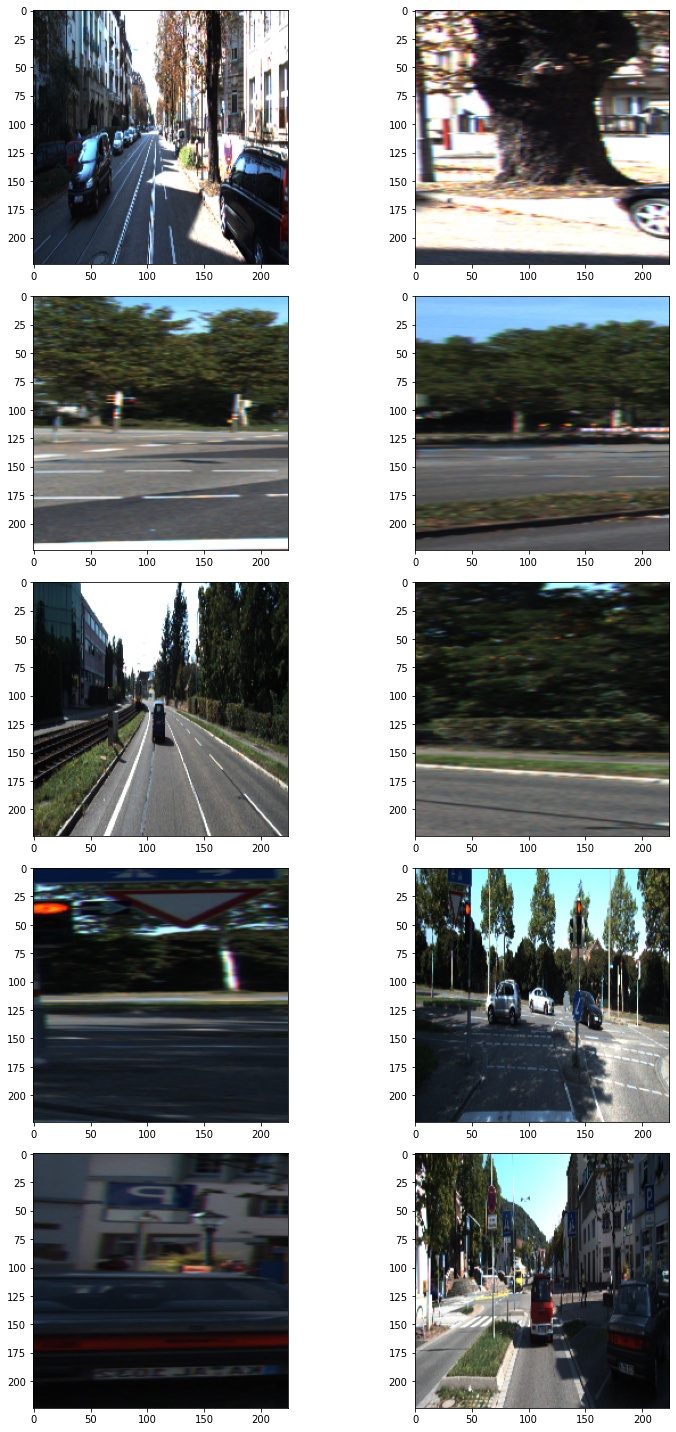

In [6]:
augmentation = build_augmentation()

input_images = glob(os.path.join(TRAIN_PATH, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.tight_layout()
plt.show()

In [7]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
              train_path,
              batch_size=16,
              img_size=(224, 224, 3),
              output_size=(224, 224),
              is_train=True,
              augmentation=None):
    '''
    TRAIN_PATH: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.TRAIN_PATH = train_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.TRAIN_PATH = train_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.TRAIN_PATH, "image_2", "*.png"))
    label_images = glob(os.path.join(self.TRAIN_PATH, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                          index*self.batch_size:
                          (index + 1)*self.batch_size
                          ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [8]:
BATCH_SIZE = 8

In [9]:
# augmentation = build_augmentation()
train_preproc = build_augmentation(is_train=True)
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    TRAIN_PATH,
    BATCH_SIZE,
    augmentation=train_preproc,
    is_train=True
)

test_generator = KittiGenerator(
    TRAIN_PATH,
    BATCH_SIZE, 
    augmentation=test_preproc,
    is_train=False
)

### Step 2. U-Net++ 모델의 구현

U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다. 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.

In [10]:
EPOCHS = 100

#### U-Net 구현

- 모델 구조
    - 세그멘테이션 모델 중 구조상 비교적 구현 단순
    - Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
    - 논문대로 Batch Normalization 적용
    - 구조<br>![](https://d3s0tskafalll9.cloudfront.net/media/images/u-net_1kfpgqE.max-800x600.png)

In [11]:
def conv_block(dim, x, concat_list=[], to_up_concat=False, to_pool=False):
    if to_up_concat:
        x = Conv2DTranspose(dim, 2, activation='elu', strides=(2,2), kernel_initializer='he_normal')(x)  # Up Sampling
        concat_list.append(x)
        x = concatenate(concat_list, axis = 3)  # Skip Connection

    x = Conv2D(dim, 3, activation='elu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)
    x = Conv2D(dim, 3, activation='elu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)

    if to_pool:
        x = MaxPooling2D(pool_size=(2, 2))(x)  # Down Sampling

    return x


def get_model_outputs(x):
    x = Conv2D(2, 3, activation='elu', padding='same',kernel_initializer='he_normal')(x)     
    x = Conv2D(1, 1, activation='sigmoid')(x)

    return x

In [12]:
def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    filter_list = [64,128,256,512,1024]

    # Contracting Path (Left)
    conv1 = conv_block(filter_list[0], inputs)
    conv2 = conv_block(filter_list[1], conv1, to_pool=True)
    conv3 = conv_block(filter_list[2], conv2, to_pool=True)
    conv4 = conv_block(filter_list[3], conv3, to_pool=True)

    conv5 = conv_block(filter_list[4], conv4, to_pool=True)  # (Middle)

    # Expanding Path (Right)
    conv6 = conv_block(filter_list[3], conv5, [conv4], to_up_concat=True)
    conv7 = conv_block(filter_list[2], conv6, [conv3], to_up_concat=True)
    conv8 = conv_block(filter_list[1], conv7, [conv2], to_up_concat=True)
    conv9 = conv_block(filter_list[0], conv8, [conv1], to_up_concat=True)

    outputs = get_model_outputs(conv9)

    # U-Net 생성
    model = Model(inputs = inputs, outputs = outputs)
    return model

- 모델 생성

In [13]:
unet = build_unet()

- 모델 구조

In [14]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

- 모델 구조 시각화

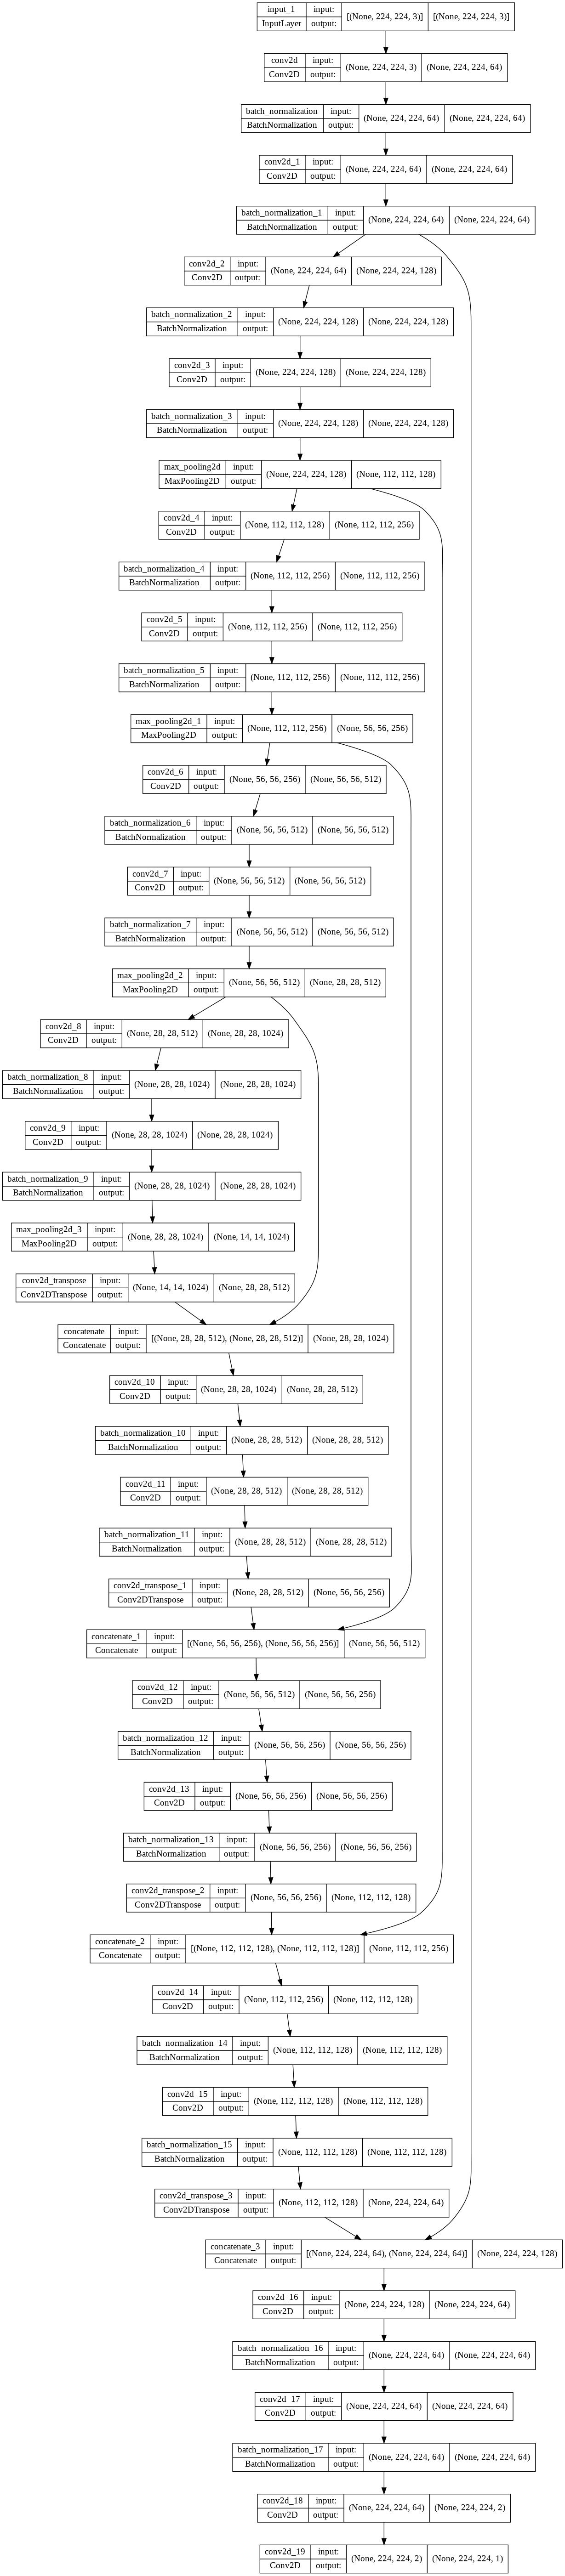

In [15]:
plot_model(unet, to_file=os.path.join(DATA_DIR, f'U-Net_shapes.png'), show_shapes=True)

- 모델 학습

In [16]:
unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=['accuracy'])
unet_history = unet.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
)

Epoch 1/100
22/22 [==============================] - 14s 353ms/step - loss: 0.4970 - accuracy: 0.6987 - val_loss: 0.9172 - val_accuracy: 0.0469
Epoch 2/100
22/22 [==============================] - 7s 332ms/step - loss: 0.2972 - accuracy: 0.8029 - val_loss: 0.9783 - val_accuracy: 0.0339
Epoch 3/100
22/22 [==============================] - 7s 332ms/step - loss: 0.2405 - accuracy: 0.8167 - val_loss: 0.9446 - val_accuracy: 0.0339
Epoch 4/100
22/22 [==============================] - 7s 332ms/step - loss: 0.2130 - accuracy: 0.8304 - val_loss: 0.9305 - val_accuracy: 0.0339
Epoch 5/100
22/22 [==============================] - 7s 332ms/step - loss: 0.2013 - accuracy: 0.8287 - val_loss: 0.8900 - val_accuracy: 0.0339
Epoch 6/100
22/22 [==============================] - 7s 333ms/step - loss: 0.1840 - accuracy: 0.8466 - val_loss: 0.8633 - val_accuracy: 0.0339
Epoch 7/100
22/22 [==============================] - 7s 332ms/step - loss: 0.1378 - accuracy: 0.9013 - val_loss: 0.8628 - val_accuracy: 0.033

- 학습 결과 시각화

In [17]:
def draw_unet_history(history, model_name='U-Net'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.savefig(os.path.join(DATA_DIR, f'{model_name}_Result.png'))  # 저장
    plt.show()

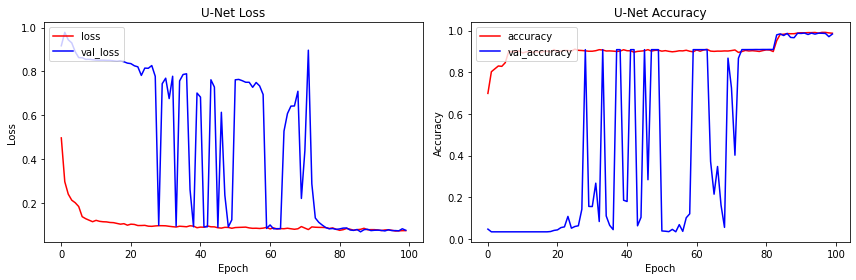

In [18]:
draw_unet_history(unet_history, 'U-Net')

- 모델 저장

In [19]:
UNET_PATH = os.path.join(DATA_DIR, 'seg_model_unet.h5')

In [20]:
unet.save(UNET_PATH)  # 학습한 모델을 저장해 주세요.

#### U-Net++ 구현

- 모델 구조
    - U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델
    - 구조<br>![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-5-P-UNPP.max-800x600.png)
    - up_block 방식: Transpose2D_block 과 Upsample2D_block 중 하나 사용
    - Loss = binary cross-entropy + dice coefficient
    - **Deep Supervision** : 각 브랜치의 출력(빨간색 선으로 표시된 부분)을 평균해서 최종 결과로서 사용하는 방법

In [21]:
def build_unet_pp(input_shape=(224, 224, 3), deep_supervision=True):
    inputs = Input(input_shape)

    filter_list = [64,128,256,512,1024]

    x_00 = conv_block(filter_list[0], inputs)
    x_10 = conv_block(filter_list[1], x_00, to_pool=True)
    x_20 = conv_block(filter_list[2], x_10, to_pool=True)
    x_30 = conv_block(filter_list[3], x_20, to_pool=True)
    x_40 = conv_block(filter_list[4], x_30, to_pool=True)

    x_01 = conv_block(filter_list[0], x_10, [x_00], to_up_concat=True)
    x_11 = conv_block(filter_list[1], x_20, [x_10], to_up_concat=True)
    x_21 = conv_block(filter_list[2], x_30, [x_20], to_up_concat=True)

    x_02 = conv_block(filter_list[0], x_11, [x_00,x_01], to_up_concat=True)
    x_12 = conv_block(filter_list[1], x_21, [x_10,x_11], to_up_concat=True)

    x_03 = conv_block(filter_list[0], x_12, [x_00,x_01,x_02], to_up_concat=True)

    x_31 = conv_block(filter_list[3], x_40, [x_30], to_up_concat=True)
    x_22 = conv_block(filter_list[2], x_31, [x_20], to_up_concat=True)
    x_13 = conv_block(filter_list[1], x_22, [x_10], to_up_concat=True)
    x_04 = conv_block(filter_list[0], x_13, [x_00,x_01,x_02,x_03], to_up_concat=True)

    if deep_supervision:
        x_01_outputs = get_model_outputs(x_01)
        x_02_outputs = get_model_outputs(x_02)
        x_03_outputs = get_model_outputs(x_03)
        x_04_outputs = get_model_outputs(x_04)

        outputs_list = [x_01_outputs, x_02_outputs, x_03_outputs, x_04_outputs]
        outputs = tf.keras.layers.Average()(outputs_list)  # 레이어 모든 값 평균 계산 => sum(outputs_list)/len(outputs_list) 과 결과 같음
    else:
        outputs = get_model_outputs(x_04)

    # U-Net++ 생성
    model = Model(inputs = inputs, outputs = outputs)
    return model

- 모델 생성

In [22]:
unet_pp = build_unet_pp()

- 모델 구조

In [23]:
unet_pp.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 224, 224, 64  256        ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

- 모델 구조 시각화

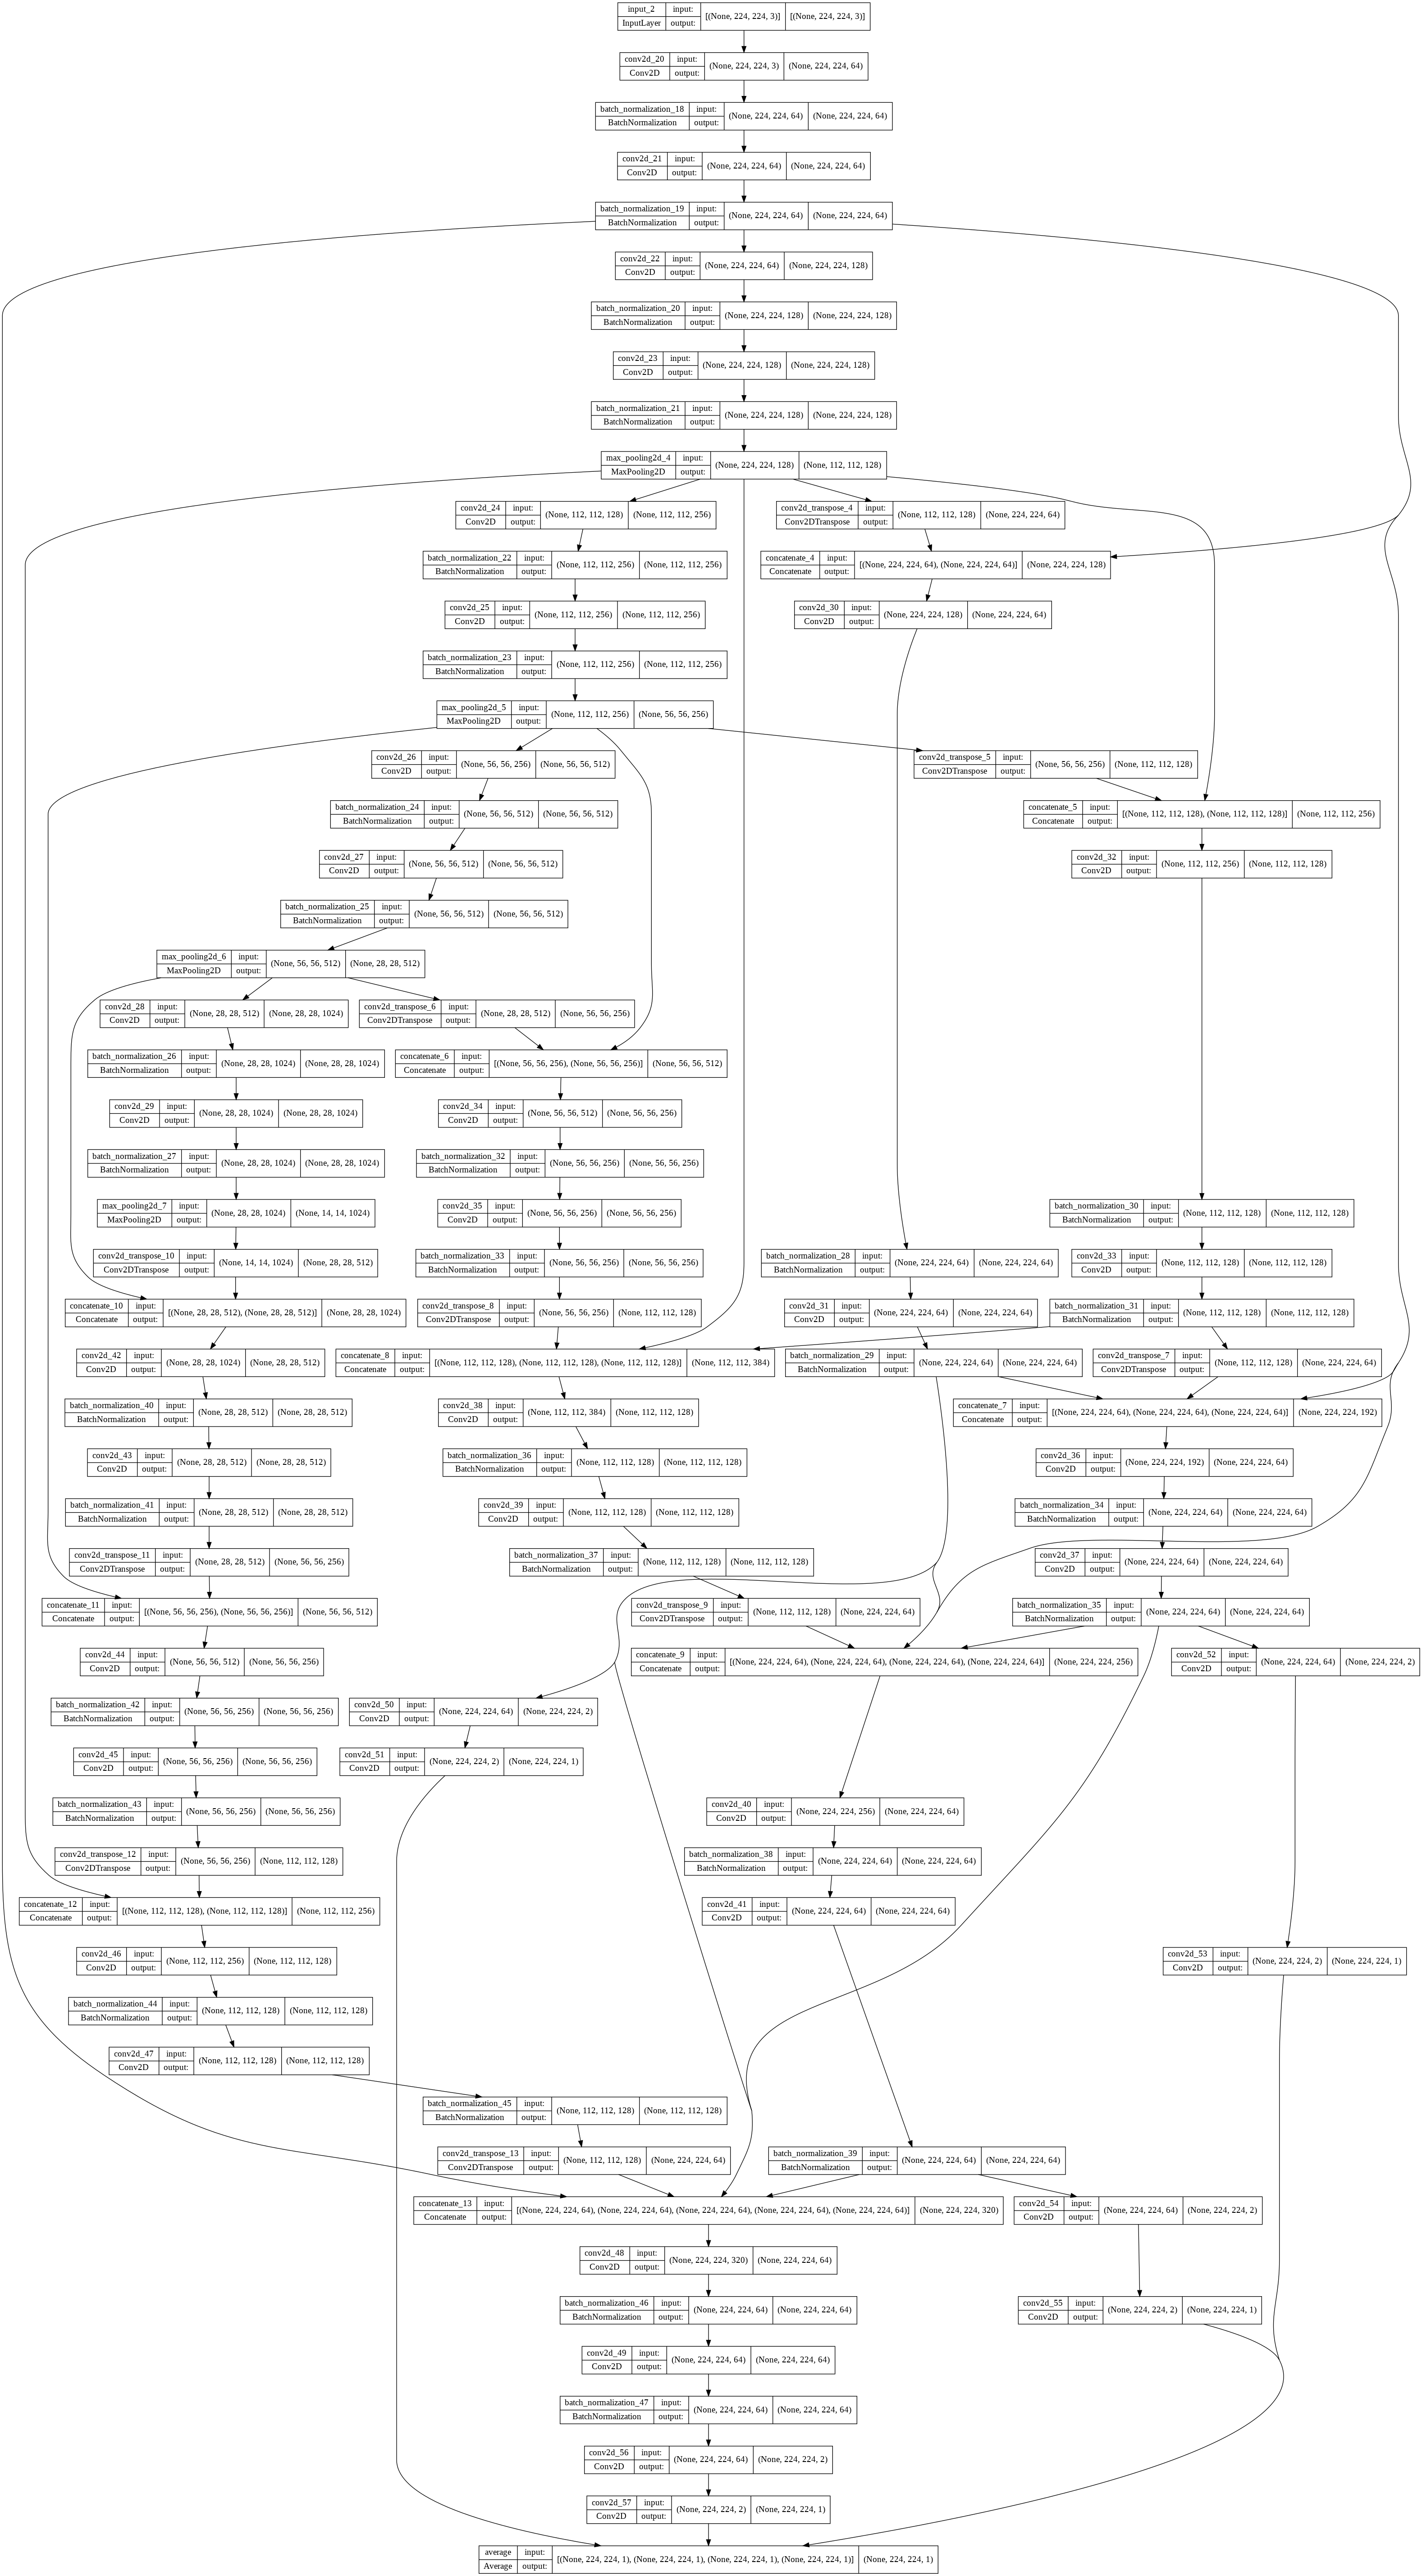

In [24]:
plot_model(unet_pp, to_file=os.path.join(DATA_DIR, f'U-Net++_shapes.png'), show_shapes=True)

- 모델 학습
  - Custom Loss 사용 [[코드 출처]](https://github.com/MrGiovanni/UNetPlusPlus/blob/master/keras/helper_functions.py)
  - Binary Cross Entropy + Dice Coefficient [[설명 출처]](https://aigong.tistory.com/154)
    - Binary Cross Entropy
      - Classification 에서 사용
      - Segmentation 에서 사용하면 물체가 작아도 Similarity 가 좋게 나오는 단점
      - 해결하기 위해 WCE(Weighted CE), BCE(Balancde CE) 사용할 수 있음
    - Dice Coefficient
      - 정답과 예측값이 완전히 같으면 1(=Dice Loss는 0), 완전히 다르면 0(=Dice Loss는 1)
      - Dice Loss
        - 정답과 예측값이 완전히 같으면 0, 완전히 다르면 1
        - 분모가 0이 되는 것을 방지하기 위해 분모, 분자에 1을 더함

In [25]:
from keras import backend as K

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [26]:
unet_pp.compile(
    optimizer = Adam(1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

unet_pp_history = unet_pp.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
)

Epoch 1/100
22/22 [==============================] - 19s 645ms/step - loss: 0.1804 - dice_coef: 0.0967 - val_loss: 0.2242 - val_dice_coef: 0.0878
Epoch 2/100
22/22 [==============================] - 13s 608ms/step - loss: 0.1051 - dice_coef: 0.1149 - val_loss: 0.1925 - val_dice_coef: 0.0816
Epoch 3/100
22/22 [==============================] - 13s 608ms/step - loss: 0.0650 - dice_coef: 0.1354 - val_loss: 0.1874 - val_dice_coef: 0.0749
Epoch 4/100
22/22 [==============================] - 13s 608ms/step - loss: 0.0795 - dice_coef: 0.1111 - val_loss: 0.2409 - val_dice_coef: 0.0687
Epoch 5/100
22/22 [==============================] - 13s 608ms/step - loss: 0.0369 - dice_coef: 0.1416 - val_loss: 0.1952 - val_dice_coef: 0.0730
Epoch 6/100
22/22 [==============================] - 13s 608ms/step - loss: 0.0249 - dice_coef: 0.1473 - val_loss: 0.1845 - val_dice_coef: 0.0972
Epoch 7/100
22/22 [==============================] - 13s 608ms/step - loss: -0.0082 - dice_coef: 0.1737 - val_loss: 0.1891 -

- 학습 결과 시각화

In [27]:
def draw_unet_history(history, model_name='U-Net'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Dice Coef 시각화
    plt.subplot(122)
    plt.plot(history.history['dice_coef'], 'r')
    plt.plot(history.history['val_dice_coef'], 'b')
    plt.title(f'{model_name} Dice Coef')
    plt.ylabel(f'{model_name} Dice Coef')
    plt.xlabel('Epoch')
    plt.legend(['dice_coef', 'val_dice_coef'], loc='upper left')

    plt.tight_layout()
    plt.savefig(os.path.join(DATA_DIR, f'{model_name}_Result.png'))  # 저장
    plt.show()

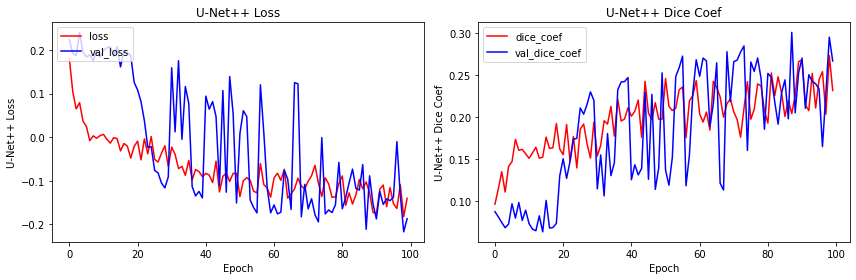

In [28]:
draw_unet_history(unet_pp_history, model_name='U-Net++')

- 모델 저장

In [29]:
UNET_PP_PATH = os.path.join(DATA_DIR, 'seg_model_unet++.h5')

In [30]:
unet_pp.save(UNET_PP_PATH)  # 학습한 모델을 저장해 주세요.

### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

- IoU(Intersection over Union) 계산 함수
    - 세그멘테이션이 성능을 정량적으로 측정하기 위한 방법

In [64]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    return iou_score

- 모델 추론(inference) 결과 시각화 및 반환 함수
    - 모델 추론 결과 시각화(output)
        - 입력 이미지와 라벨을 한 번에 볼 수 있도록 오버레이(overray) => 세그멘테이션 이미지 생성
        - PIL 패키지 Image.blend 활용
    - 모델 추론 결과(prediction, target)
        - prediction = 모델이 도로 영역이라고 판단한 부분 1, 나머지 부분 0 인 행렬
        - target = 라벨 데이터에서 도로 영역 1, 나머지 부분 0 인 행렬
    - **[참고](https://lapina.tistory.com/81) Colab 에서는 PIL 명령어 show() 로 이미지가 열리지 않음!! => plt.show() 로 해결**
        - PIL 명령어 show(): 기본 OS에 깔린 유틸리티로 이미지를 열게 해주는 기능 => 온라인 기반 IPython에는 그런 실행이 불가능함
        - Colab, Jupyter notebook은 IPython 을 이용한 명령쉘

In [55]:
def get_output(model, preproc, image_path, output_path_dict, label_path, is_unet_pp=False, to_visualize=False):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역

    output_detect = Image.fromarray(output)
    output_detect = output_detect.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output_detect.save(output_path_dict['detect'], 'png')  # 저장 # 도로 detection

    background = Image.fromarray(origin_img).convert('RGBA')
    output_blend = Image.blend(background, output_detect, alpha=0.5)
    output_blend.save(output_path_dict['blend'], 'png')  # 저장 # 도로 detection + 원본 이미지

    if to_visualize:
        # 시각화 및 저장
        plt.figure(figsize=(12,6))

        plt.subplot(211)
        plt.title('Detection')
        plt.axis('off')
        plt.imshow(output_detect)

        plt.subplot(212)
        plt.title('Blend')
        plt.axis('off')
        plt.imshow(output_blend)

        plt.tight_layout()
        plt.savefig(output_path_dict['all'])  # 저장 # 이미지 2개 같이 저장
        plt.show()
    
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로(7)로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

#### U-Net 세그멘테이션 결과

- 모델 불러오기

In [56]:
unet = tf.keras.models.load_model(UNET_PATH)

- 모델 추론 결과 시각화

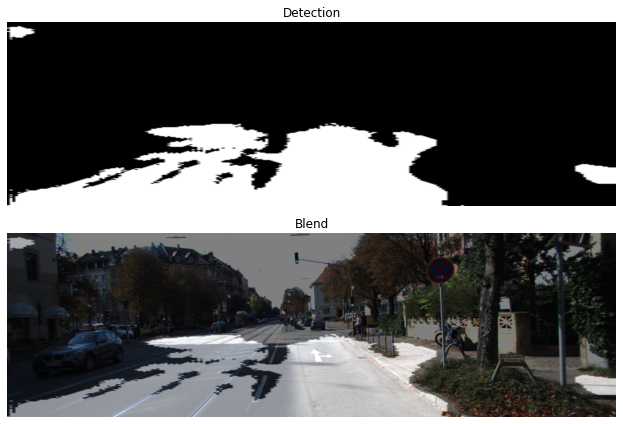

In [57]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output_unet, prediction_unet, target_unet = get_output(
    unet, 
    test_preproc,
    image_path=TRAIN_PATH + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path_dict={
                      'detect': TRAIN_PATH + f'/unet_result_{str(i).zfill(3)}_detect.png',
                      'blend': TRAIN_PATH + f'/unet_result_{str(i).zfill(3)}_blend.png',
                      'all': TRAIN_PATH + f'/unet_result_{str(i).zfill(3)}_all.png',
                      },
    label_path=TRAIN_PATH + f'/semantic/00{str(i).zfill(4)}_10.png',
    is_unet_pp=False,
    to_visualize=True,
)

- IoU 계산 결과

In [58]:
unet_iou = calculate_iou_score(target_unet, prediction_unet)
unet_iou

IoU : 0.660315


0.6603149493061048

#### U-Net++ 세그멘테이션 결과

- 모델 불러오기
  - Custom Loss 인 bce_dice_loss() 함수를 사용했기 때문에 저장한 모델을 불러올 때 unet_pp = tf.keras.models.load_model(<model_path>) 만 쓰면 에러가 발생한다.
    - ValueError: Unknown loss function: bce_dice_loss
  - 해결 방법
    - 1) compile=False 설정
      - unet_pp = tf.keras.models.load_model(UNET_PP_PATH, compile=False)
    - 2) argument 로 custom_objects 설정 [[참고]](https://www.tensorflow.org/guide/keras/save_and_serialize)
      - unet_pp = tf.keras.models.load_model(UNET_PP_PATH, custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss, 'bce_dice_loss': bce_dice_loss})

```python
# 일반적으로 모델 불러오면 에러 발생
unet_pp = tf.keras.models.load_model(UNET_PP_PATH)

# 출력된 에러
# ValueError: Unknown loss function: bce_dice_loss. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
```

```python
# 해결 방법 1
unet_pp = tf.keras.models.load_model(UNET_PP_PATH, compile=False)

# 해결 방법 2
unet_pp = tf.keras.models.load_model(UNET_PP_PATH, custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss, 'bce_dice_loss': bce_dice_loss})
```


In [59]:
unet_pp = tf.keras.models.load_model(UNET_PP_PATH, compile=False)

- 모델 추론 결과 시각화

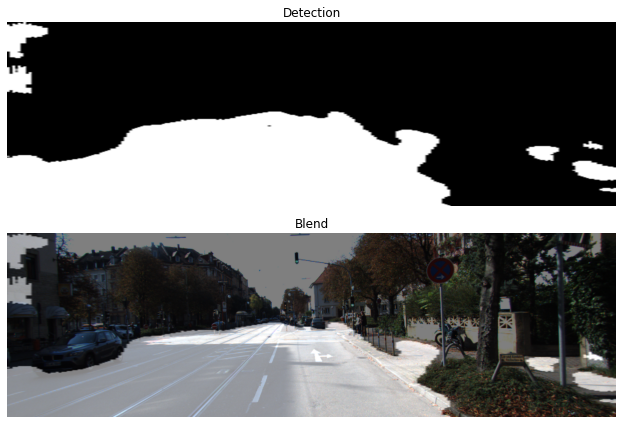

In [60]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output_unet_pp, prediction_unet_pp, target_unet_pp = get_output(
    unet_pp, 
    test_preproc,
    image_path=TRAIN_PATH + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path_dict={
                      'detect': TRAIN_PATH + f'/unet++_result_{str(i).zfill(3)}_detect.png',
                      'blend': TRAIN_PATH + f'/unet++_result_{str(i).zfill(3)}_blend.png',
                      'all': TRAIN_PATH + f'/unet++_result_{str(i).zfill(3)}_all.png',
                      },
    label_path=TRAIN_PATH + f'/semantic/00{str(i).zfill(4)}_10.png',
    is_unet_pp=True,
    to_visualize=True,
)

- IoU 계산 결과

In [61]:
unet_pp_iou = calculate_iou_score(target_unet_pp, prediction_unet_pp)
unet_pp_iou

IoU : 0.813659


0.8136589778380823

---

### 모든 테스트 이미지 결과 확인

- 추론 결과 저장 및 IoU 계산

In [79]:
def visualize_inference_and_get_iou(model, model_name='unet', is_unet_pp=False, to_visualize=False):
    iou = {}

    for i in range(len(os.listdir(os.path.join(TRAIN_PATH, 'image_2')))):
        output_unet, prediction_unet, target_unet = get_output(
            model, 
            test_preproc,
            image_path=TRAIN_PATH + f'/image_2/00{str(i).zfill(4)}_10.png',
            output_path_dict={
                              'detect': TRAIN_PATH + f'/{model_name}/{str(i).zfill(3)}_detect.png',
                              'blend': TRAIN_PATH + f'/{model_name}/{str(i).zfill(3)}_blend.png',
                              'all': TRAIN_PATH + f'/{model_name}/{str(i).zfill(3)}_all.png',
                              },
            label_path=TRAIN_PATH + f'/semantic/00{str(i).zfill(4)}_10.png',
            is_unet_pp=is_unet_pp,
            to_visualize=to_visualize,
        )

        iou[f'00{str(i).zfill(4)}_10.png'] = calculate_iou_score(target_unet, prediction_unet)

    return iou

In [80]:
unet_iou_dict = visualize_inference_and_get_iou(model=unet, model_name='unet', is_unet_pp=False, to_visualize=False)

In [81]:
unet_pp_iou_dict = visualize_inference_and_get_iou(model=unet_pp, model_name='unet_pp', is_unet_pp=True, to_visualize=False)

In [82]:
iou_all = pd.DataFrame({'unet_iou': unet_iou_dict.values(), 'unet_pp_iou': unet_pp_iou_dict.values()}, index=unet_iou_dict.keys())
iou_all

unet_iou  unet_pp_iou
000000_10.png  0.289195     0.753190
000001_10.png  0.660315     0.813659
000002_10.png  0.454772     0.667956
000003_10.png  0.441875     0.696288
000004_10.png  0.732919     0.685143
...                 ...          ...
000195_10.png  0.544524     0.900852
000196_10.png  0.584403     0.646666
000197_10.png  0.000224     0.000567
000198_10.png  0.011158     0.007672
000199_10.png  0.000658     0.004493

[200 rows x 2 columns]

- IoU 히트맵

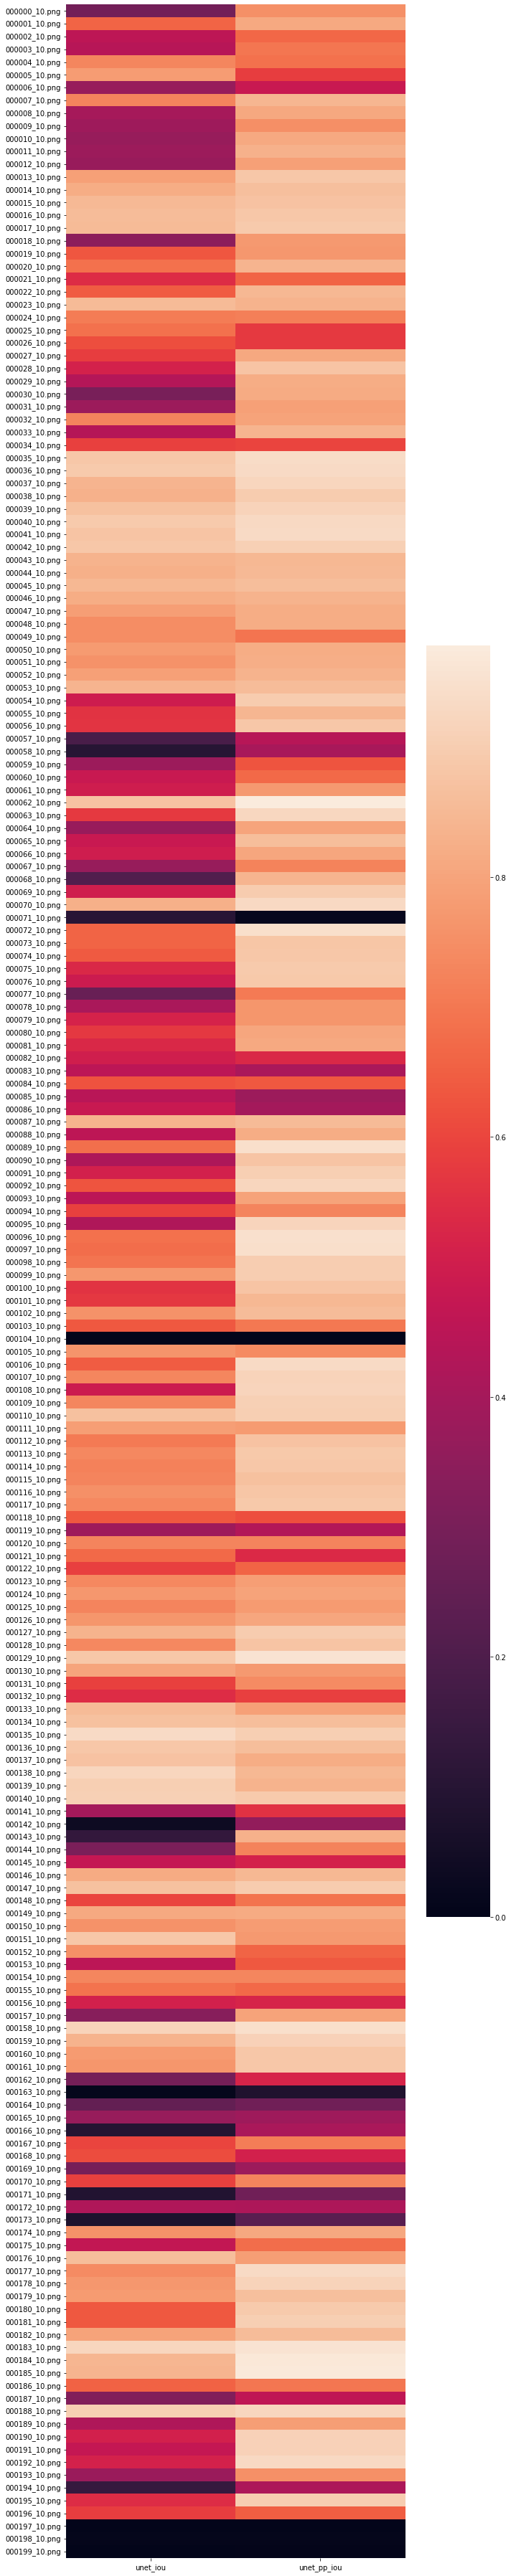

In [99]:
import seaborn as sns

plt.figure(figsize=(10,50))
sns.heatmap(iou_all)
plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'iou_heatmap.png'))
plt.show()

---

### 결과 정리

- 학습 결과

||U-Net|U-Net++|
|:---:|:---:|:---:|
|학습 결과|![](result/U-Net_Result.png)|![](result/U-Net%2B%2B_Result.png)|

- 추론 결과 시각화(정성적 비교) 및 IoU 계산(정량적 비교)

|i=1|U-Net|U-Net++|
|:---:|:---:|:---:|
|추론 결과|![](result/unet_result_001_all.png)|![](result/unet%2B%2B_result_001_all.png)|
|IoU<br>계산|0.660315|0.813659|

- 테스트 이미지별 추론 결과 시각화(정성적 비교)

||U-Net|U-Net++|
|:---:|:---:|:---:|
|추론 결과|![](result/unet_blend.gif)|![](result/unet%2B%2B_blend.gif)|

- 테스트 이미지별 IoU 계산(정량적 비교)

In [98]:
iou_all

unet_iou  unet_pp_iou
000000_10.png  0.289195     0.753190
000001_10.png  0.660315     0.813659
000002_10.png  0.454772     0.667956
000003_10.png  0.441875     0.696288
000004_10.png  0.732919     0.685143
...                 ...          ...
000195_10.png  0.544524     0.900852
000196_10.png  0.584403     0.646666
000197_10.png  0.000224     0.000567
000198_10.png  0.011158     0.007672
000199_10.png  0.000658     0.004493

[200 rows x 2 columns]

![](result/iou_heatmap.png)

- 결론
    - 학습 그래프가 U-Net 과 U-Net++ 모두 극단적으로 들쭉날쭉하는데 이유를 모르겠다. 하지만 전반적으로 Epoch 이 지남에 따라 loss 는 낮아지고 accuracy 또는 Dice Coef 는 높아져서 정상적으로 학습됐다고 볼 수 있다.
    - Inference 를 원본 이미지에 오버레이하여 시각화해본 결과, U-Net++ 이 좀 더 먼 곳까지 영역 표시한 것을 볼 수 있다.
    - IoU 히트맵 색이 대부분 U-Net 보다 U-Net++ 이 더 연했다. => 연할수록 1에 가깝다. => 도로 영역을 잘 찾아낸다.

=> **성능: U-Net < U-Net++**

---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
U-Net++ 모델을 구현하고 학습해서 저장하고 불러오고 사용하기까지 모든 과정이 만만치 않았다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- [Semantic Segmentation KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/eval_semantics.php)
- Computer Vision 에서 다뤄지는 문제 유형 [[참고]](https://medium.com/hyunjulie/1%ED%8E%B8-semantic-segmentation-%EC%B2%AB%EA%B1%B8%EC%9D%8C-4180367ec9cb)
  - Classification (분류): 인풋에 대해서 하나의 레이블을 예측하는 작업 # AlexNet, ResNet, Xception 등의 모델
  - Localization/Detection (발견): 물체의 레이블을 예측하면서 그 물체가 어디에 있는지 정보를 제공. 물체가 있는 곳에 네모를 그림 # YOLO, R-CNN 등의 모델
  - Segmentation (분할): 모든 픽셀의 레이블을 예측 # FCN, SegNet, DeepLab 등의 모델
- Semantic Segmentation
  - 모든 픽셀의 class 예측
  - 딥러닝 모델 역사<br>![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fw80ps%2Fbtq8abmwhVI%2FJfdkyFrx3QwzPLKHUkxZUk%2Fimg.png)
- U-Net
    - Segmentation을 목적으로 제안된 End-to-End 방식의 Fully-Convolutional 기반의 모델
    - 의료 분야의 이미지를 다루기 위한 목적으로 제안됨
    - 구조<br>![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FzInhB%2FbtqKrLTuS3n%2FnL86mIqbNkwTnaXpRkMEdk%2Fimg.png)
        - Contracting Path(수축 경로) : 큰 입력 이미지로부터 이미지 픽셀의 차원을 축소하면서 의미(Context)있는 정보를 추출하는 부분 => 일반적인 CNN Architecture가 작동하는 부분과 같음
        - **Expanding Path(확장 경로)** : 수축 경로에서 추출된 의미정보와 수축 경로에서 각 Layer에 존재하는 픽셀의 위치정보를 결합(Skip)하여 Up-Sampling을 진행하는 부분 => Contracting Path에서 축소하였던 정보를, 원래의 이미지와 픽셀 단위로 비교하기 위해서는 같은 크기의 픽셀로 복원시킴
- U-Net++ [[v1; 2018]](https://arxiv.org/abs/1807.10165) [[v2; 2020]](https://arxiv.org/abs/1912.05074)
    - **U-Net의 네트워크 구조 + DenseNet** 의 아이디어로 성능을 개선한 모델
    - 구조<br>![](https://blog.promedius.ai/content/images/size/w2000/2022/02/image11-1.jpeg)
        - Re-designed skip pathways : DenseNet의 아이디어를 차용하여 Encoder(수축 경로)와 Decoder(확장 경로)사이의 Semantic(의미적) Gap을 연결시켜 줌
        - **Deep Supervision** : 각 브랜치의 출력(빨간색 선으로 표시된 부분)을 평균해서 최종 결과로서 사용하는 방법
    - 코드 참고: [[1]](https://github.com/CarryHJR/Nested-UNet/blob/master/model.py) [[2]](https://wsshin.tistory.com/2) [[3]](https://eda-ai-lab.tistory.com/587?category=820209)
- Segmentation Metric [[참고1]](https://aigong.tistory.com/155) [[참고2]](https://www.programmersought.com/article/47276704061/)
  - Pixel Accuracy
    - Classification 에서 많이 사용하는 정확도
    - 1% 물체(TP)와 99% 배경(TN)을 보고 높은 정확도를 보일 수 있음 => Segmentation 에서 적합하지 않은 Metric
  - Dice Coefficient [[참고]](http://machinelearningkorea.com/2019/07/13/%ED%8F%89%EA%B0%80%EC%A7%80%ED%91%9C-dice/)
    - 주로 Medical Image Analysis 에서 사용
    - 이미지 등의 Segmentation 에서 쓰이는 지표
    - 정답과 예측값 간의 차이를 알기 위해 사용
      - 라벨링된 영역과 예측한 영역이 정확히 같다면, 1이되며 그렇지 않을 경우에는 0이 된다.
    - $\text{Dice(A,B)} = \frac {2|A \cap B|}{|A|+|B|}$
    - $\text{Dice} = \frac {2 \times TP}{(TP+FP) + (TP+FN)}$
    - Dice를 boolean data(binary segmentation map)에 적용할 때, Dice coefficient는 F1 score와 동일하다.
      - $\text{Dice} = \frac {2TP}{2TP+FP+FN} = \text{F1}$
  - IoU(Intersection over Union)
    - Object Detection 에서 많이 사용하는 Metric
    - 겹쳐지는 부분을 기준으로 많이 겹쳐지면 1, 겹치는 것이 없다면 0
    - $\text{IoU(A,B)} = \frac {|A \cap B|}{|A \cup B|}$
    - $\text{IoU} = \frac {TP}{TP+FP+FN}$
    - $\text{IoU} = \frac {Dice}{2-Dice}$
  - HD(Hausdorff Distance)
    - 1) A에 해당하는 픽셀 중 하나의 점 a와 모든 B의 점들 중 distance가 가장 작은 곳 선택
    - 2) 1)에서 구한 방법으로 A 안의 모든 점들 간 distance를 구함
    - 3) 2) 중 가장 큰 값 선택
  - AVD(Average Distance): 포인트별 최소 거리를 기준으로 평균 냄

### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?|KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.|
>|2|U-Net++ 모델이 성공적으로 구현되었는가?|U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.|
>|3|U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?|U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.|

U-Net 과 U-Net++ 모델 모두 구현 및 학습을 진행했다. 기존 lms 코드로는 모델 구현에서 dropout 이 있었지만 논문에서는 batch normalization 을 사용했다고 해서 그걸로 바꿔서 구현했다. 세그멘테이션 결과 시각화 및 IoU 계산값의 비교를 통해 U-Net++(0.81) 이 U-Net(0.66) 보다 성능이 좋았음을 알 수 있었다. 추가적으로 테스트 이미지별 세그멘테이션 결과 확인 및 IoU 계산값 히트맵을 그려보았다. 대부분 U-Net 보다 U-Net++ IoU 히트맵 색이 연했다. 그만큼 도로 영역을 상대적으로 더 잘 찾아내었음을 뜻한다.


### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
빨리 끝내고 다른 것을 해야 된다. 숨 막힌다.